In [1]:
import sys
sys.path.append("..")

from ris_evaluation.evaluator import Evaluator

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

In [3]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

lda = LatentDirichletAllocation(n_components=len(set(labels)), random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=0)

In [4]:
results_df = pd.DataFrame()
results_df['document'] = documents
results_df['y_true'] = documents_df['class_name'].tolist()
results_df['y_pred'] = lda.transform(X).argmax(axis=1)
results_df['y_pred_highest_proba'] = lda.transform(X).max(axis=1)

results_df

,document,y_true,y_pred,y_pred_highest_proba
0,hit shelf combine medium player phone gaming g...,tech,2,0.910652
1,bid hope join host apply host tournament aim r...,sport,1,0.818584
2,lord wrong detainee straw straw attack decisio...,politics,3,0.758257
3,leak answer minister explain budget detail pri...,politics,0,0.571255
4,delight manager pay tribute goal striker beat ...,sport,1,0.977416
...,...,...,...,...
2220,rock clean steer clear bad language front awar...,entertainment,2,0.884496
2221,comedy meet sequel meet parent top week movie ...,entertainment,2,0.939132
2222,join rare group actress nominate oscar star fo...,entertainment,2,0.878861
2223,police chief back move chief back introduction...,politics,0,0.878932


In [5]:
def get_words_for_topics(topics: list):
    """ Returns a dictionary with the words for each topic.

    Args:
        topics (list): List of topics. 
    
    Returns:
        dict: Dictionary with the words for each topic.
    """
    words_by_topics = {}
    for idx, topic in enumerate(topics):
        words = documents_df.iloc[idx]['document'].split()

        if topic not in words_by_topics:
            words_by_topics[topic] = {}

        for word in words:
            if word not in words_by_topics[topic]:
                words_by_topics[topic][word] = 0

            words_by_topics[topic][word] += 1

    return words_by_topics

In [6]:
def get_output(lda_model: LatentDirichletAllocation, vectorizer_model: CountVectorizer):
    """ Returns the output for the LDA model on the OCTIS format.

    Args: 
        lda_model (LatentDirichletAllocation): LDA model.
        vectorizer_model (CountVectorizer): Vectorizer model.

    Returns:
        dict: Output for the LDA model on the OCTIS format.
    """ 
    topics = []
    for topic in lda_model.components_:
        topic_words = []
        for i in topic.argsort()[-10:]:
            topic_words.append(vectorizer_model.get_feature_names_out()[i])
        topics.append(topic_words)

    return {
        "topics": topics,
        "topic-document-matrix": None,
        "topic-word-matrix": None,
        "test-topic-document-matrix": None
    }

In [7]:
model_output = get_output(lda, vectorizer)
evaluator = Evaluator(model_output)

words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
words_by_class = get_words_for_topics(results_df['y_true'].tolist())

In [8]:
coherence = evaluator.compute_coherence()
diversity = evaluator.compute_diversity()
supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

metrics_df = pd.DataFrame()

for coherence_type, coherence_value in coherence.items():
    metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
metrics_df['Diversity'] = [diversity]
metrics_df['Supervised correlation'] = [supervised_correlation]
metrics_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.465131,-0.154971,0.023076,-2.344902,0.94,0.739535


<Axes: xlabel='y_pred', ylabel='y_pred_highest_proba'>

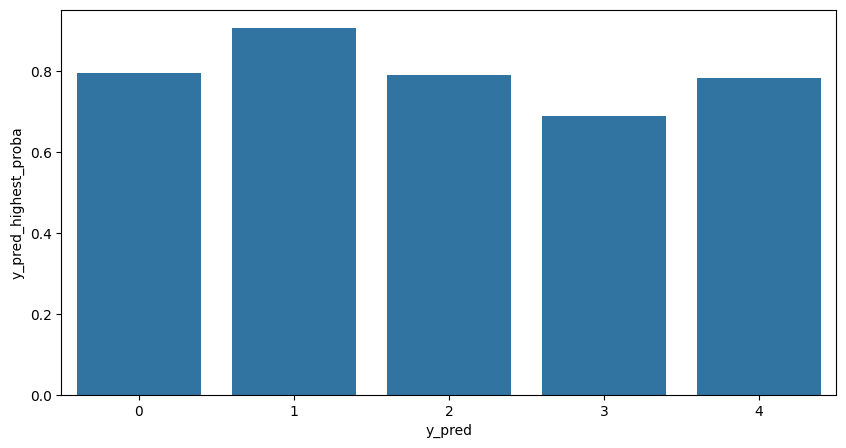

In [9]:
plt.figure(figsize=(10, 5))

sns.barplot(data=results_df, x='y_pred', y='y_pred_highest_proba', errorbar=None)

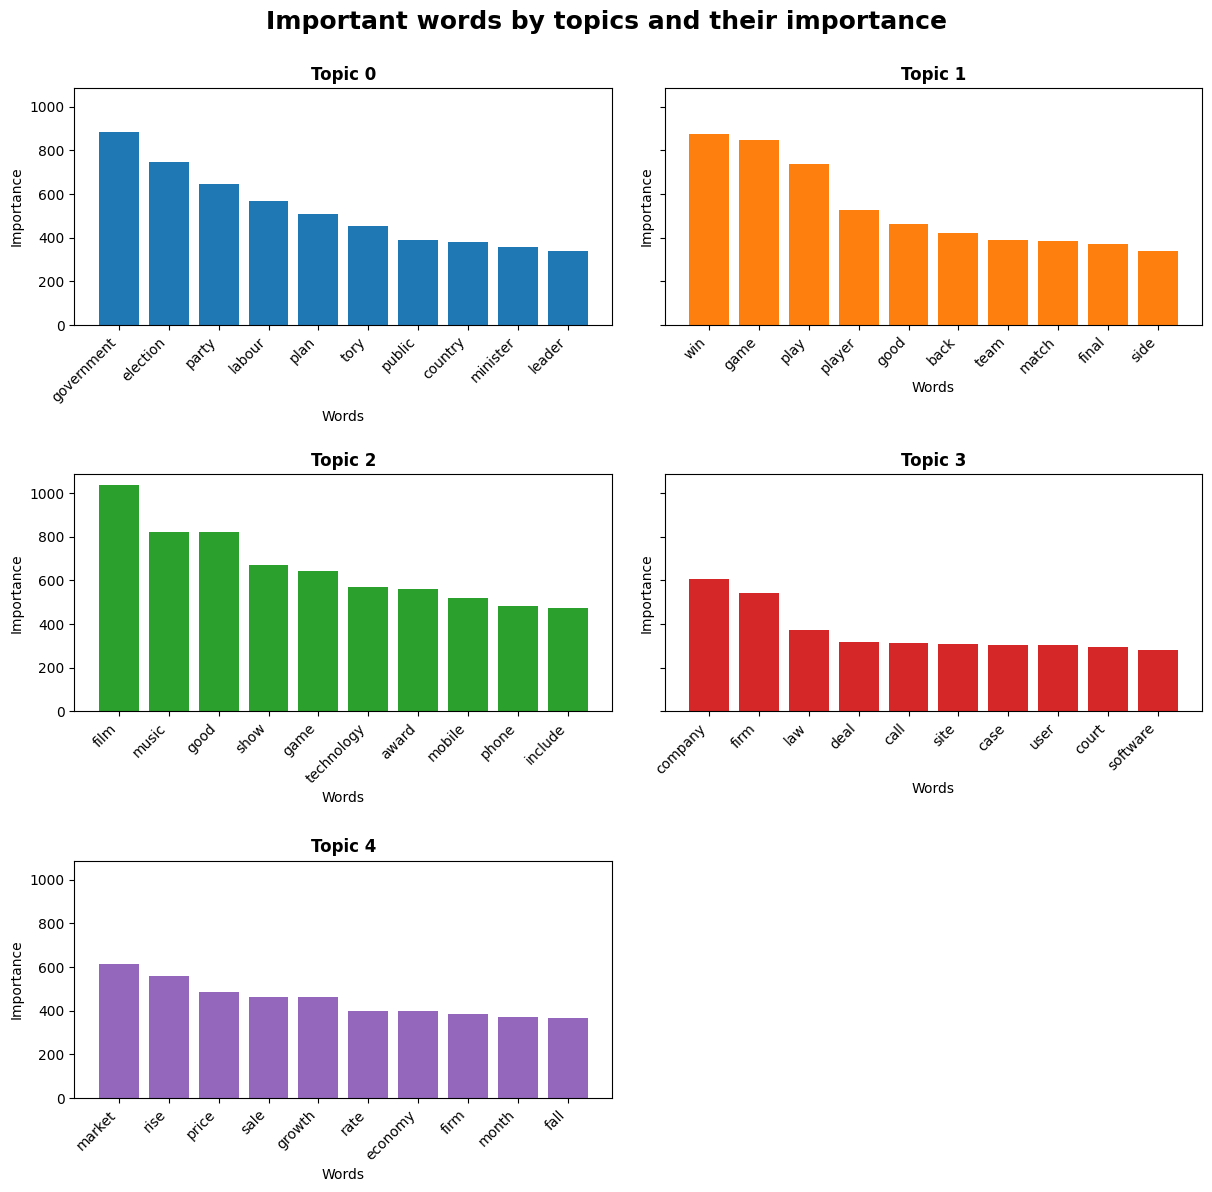

In [10]:
no_top_words = 10
x, y = 0, 0
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Plotting the important words by topics and their importance
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)
fig.suptitle('Important words by topics and their importance', fontsize=18, fontweight='bold')

for topic_idx, topic in enumerate(lda.components_):
    features = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

    ax = axes[x, y]
    ax.set_title(f'Topic {topic_idx}', fontsize=12, fontweight='bold')
    ax.bar(features, topic[topic.argsort()[:-no_top_words - 1:-1]], color=colors[topic_idx])
    ax.set_xlabel('Words')
    ax.set_ylabel('Importance')
    ax.xaxis.set_ticks(features)
    ax.set_xticklabels(features, rotation=45, ha='right')

    if y == 1:
        x += 1
        y = 0
    else:
        y += 1

fig.delaxes(axes[2, 1])
fig.tight_layout(pad=2.0, rect=[-0.02, -0.02, 1.02, 1])
fig.savefig('../../figures/lda/important_words_by_topics.png')

In [11]:
def get_word_assignment(word: str, lda_model: LatentDirichletAllocation):
    """ Returns the topic assigned to a word.

    Args:
        word (str): Word.
        lda_model (LatentDirichletAllocation): LDA model.

    Returns:
        int: Topic assigned to the word.
    """
    word_index = vectorizer.vocabulary_[word]
    return lda_model.components_[:, word_index].argmax()

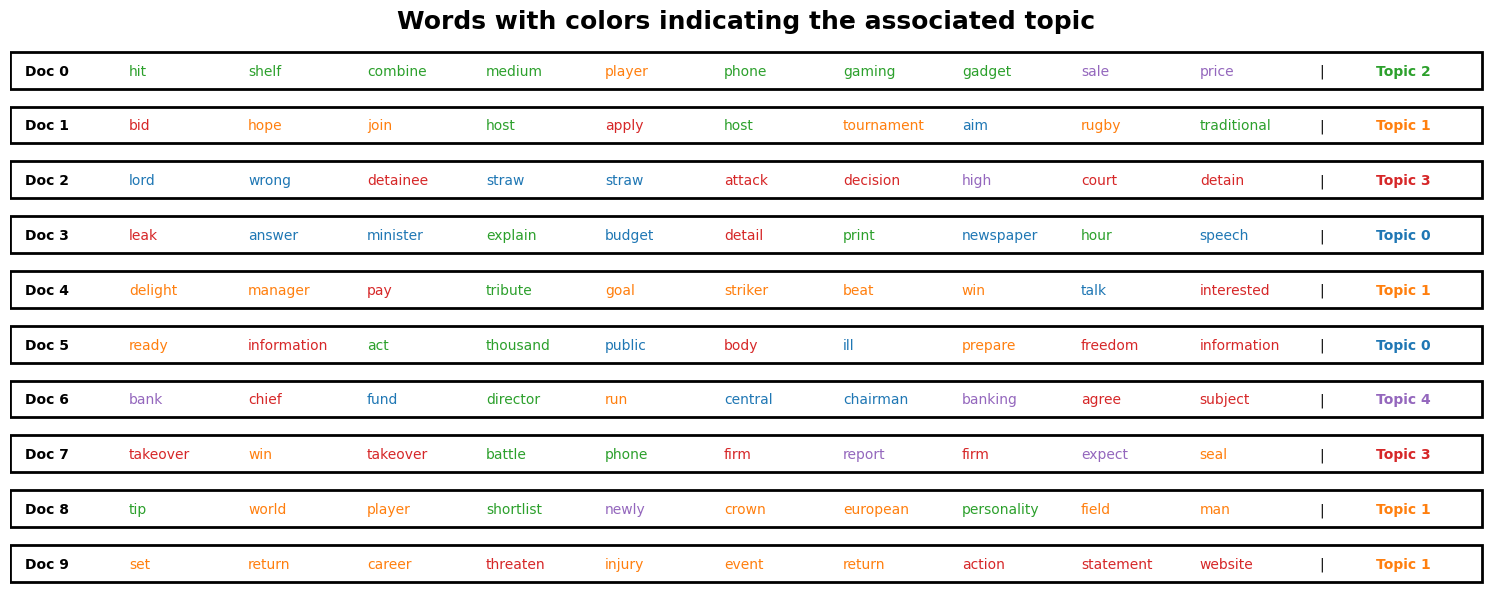

In [12]:
from matplotlib.patches import Rectangle

docs = documents[:10]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Plotting the words with colors indicating the associated topic
fig, axes = plt.subplots(10, 1, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Words with colors indicating the associated topic', fontsize=18, fontweight='bold')
axes = axes.flatten()

for doc_idx in range(len(docs)):
    doc = documents[doc_idx]
    words = doc.split()[:10]
    topics = lda.transform(vectorizer.transform([doc]))
    topic_assignments = np.argmax(topics, axis=1)
    axes[doc_idx].text(0.01, 0.37, f'Doc {doc_idx}', color='black', fontweight='bold')
    for j, word in enumerate(words):
        color = colors[get_word_assignment(word, lda)]
        axes[doc_idx].text((j + 1) * 0.08, 0.37, word, color=color)
    
    axes[doc_idx].text((len(words) + 1) * 0.08, 0.37, f'|', color='black')
    axes[doc_idx].text((len(words) + 1) * 0.0835, 0.37, f'Topic {topic_assignments[0]}', color=colors[topic_assignments[0]], fontweight='bold')

    axes[doc_idx].axis('off')
    axes[doc_idx].add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, color='black', linewidth=2))

fig.tight_layout(pad=1.0, rect=[0, 0, 1.01, 1])
fig.savefig('../../figures/lda/words_with_colors_indicating_the_associated_topic.png')

In [19]:
n_iterations = 10

results_iterations_df = pd.DataFrame()

for i in range(n_iterations):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(documents)

    lda = LatentDirichletAllocation(n_components=len(set(labels)))
    lda.fit(X)

    model_output = get_output(lda, vectorizer)
    evaluator = Evaluator(model_output)

    words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
    words_by_class = get_words_for_topics(results_df['y_true'].tolist())

    coherence = evaluator.compute_coherence()
    diversity = evaluator.compute_diversity()
    supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

    metrics_df = pd.DataFrame()
    for coherence_type, coherence_value in coherence.items():
        metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
    metrics_df['Diversity'] = [diversity]
    metrics_df['Supervised correlation'] = [supervised_correlation]

    results_iterations_df = pd.concat([results_iterations_df, metrics_df])

results_iterations_df = results_iterations_df.reset_index(drop=True)
results_iterations_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.514366,0.148032,0.044356,-2.295020,0.86,0.739535
1,0.483115,-0.538617,0.007734,-2.421846,0.92,0.739535
2,0.454703,-0.263516,0.010493,-2.344276,0.94,0.739535
3,0.509658,-0.085574,0.031974,-2.296734,0.96,0.739535
4,0.465259,-0.020215,0.031883,-2.363748,0.92,0.739535
5,0.524093,0.032273,0.039066,-2.357827,0.96,0.739535
6,0.504732,0.066462,0.040819,-2.204498,0.92,0.739535
7,0.509270,-0.016171,0.035607,-2.284279,0.88,0.739535
8,0.510648,0.012813,0.037149,-2.341994,0.94,0.739535
9,0.503911,-0.033645,0.032888,-2.280292,0.94,0.739535


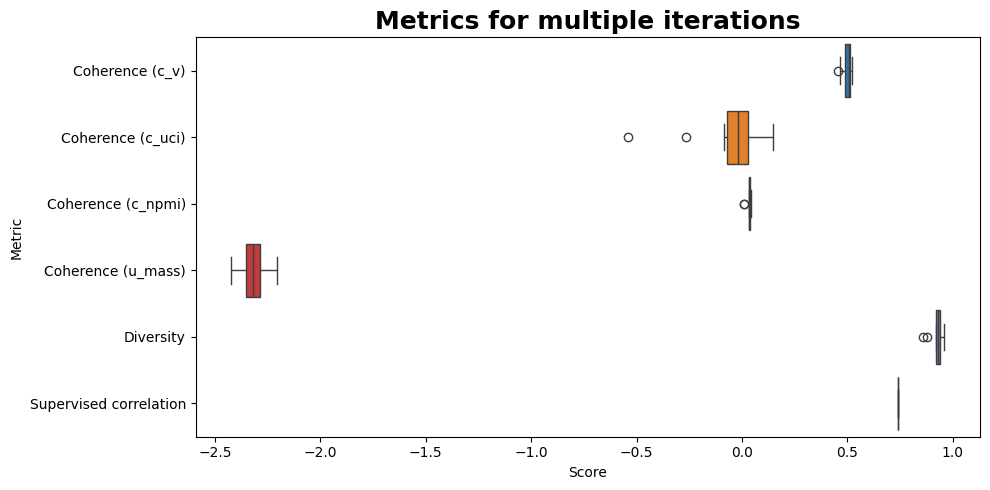

In [21]:
plt.figure(figsize=(10, 5))
plt.title('Metrics for multiple iterations', fontsize=18, fontweight='bold')

sns.boxplot(data=results_iterations_df, orient='h')
plt.xlabel('Score')
plt.ylabel('Metric')

plt.tight_layout()
plt.savefig('../../figures/lda/randomness_boxplot_metrics.png')